In [ ]:
!pip install emot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import nltk
import io
from textblob import Word
import re
import sys, os, csv
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/DL/Text-Emotion-Analysis-master.zip'

import zipfile

zip_file_path = file_path
extraction_path = '/content/Text_Emotion/'

import os
os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f'Files extracted to {extraction_path}')


Files extracted to /content/Text_Emotion/


In [ ]:
def word_prob(word): return dictionary[word] / total
def words(text): return re.findall('[a-z]+', text.lower())
dictionary = Counter(words(open('/content/Text_Emotion/Text-Emotion-Analysis-master/dataset/wordlists/merged.txt').read()))
max_word_length = max(map(len, dictionary))
total = float(sum(dictionary.values()))

def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def prep(tweet):
    """pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", str(tweet))
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', str(tweet))
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    tweet = tweet.strip()"""
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    tweet = re.sub('\d+', '', str(tweet))
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    ps = PorterStemmer()
    words = tweet.split()
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    tweet = " ".join(lemma_words)

    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = tweet.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    tweet = " ".join(clean_words)

    tweet = tweet.strip()
    return tweet

def vectorise_label(label):
    if label == "empty":return 0
    elif label == "sadness":return 2
    elif label == "enthusiasm":return 1
    elif label == "neutral":return 0
    elif label == "worry":return 2
    elif label == "surprise":return 1
    elif label == "love":return 3
    elif label == "fun":return 1
    elif label == "hate":return 4
    elif label == "happiness":return 1
    elif label == "boredom":return 0
    elif label == "relief":return 1
    elif label == "anger":return 4

In [ ]:
data1 = pd.read_csv("/content/Text_Emotion/Text-Emotion-Analysis-master/crawled_csv/sad_processes.csv", sep=',', encoding='utf-8')
!mkdir -p crawled_csv/prep
!pip install nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
dataWriter = csv.writer(open('/content/Text_Emotion/Text-Emotion-Analysis-master/crawled_csv/prep/sad_prep.csv', 'w'), delimiter=',',lineterminator="\n")
total = 2000
for i in range(1999):
    tweet= prep(data1.iloc[:,0][i])
    dataWriter.writerow([tweet, 2])
print("Done!")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Done!


In [ ]:
count = 0
with open('/content/Text_Emotion/Text-Emotion-Analysis-master/crawled_csv/prep/sad_prep.csv', encoding = "utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

1999


In [ ]:
data2 = pd.read_csv('/content/Text_Emotion/Text-Emotion-Analysis-master/dataset/data/text_emotion.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data2.shape)
print(data2.sentiment[0],":",data2.content[0])

Dataset shape: (40000, 4)
empty : @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


In [ ]:
dataWriter = csv.writer(open('/content/Text_Emotion/Text-Emotion-Analysis-master/cleaned_data/data_prep.csv', 'w', encoding='utf-8'), delimiter=',',lineterminator="\n")

total = 40000
for i in range(40000):
    tweet= prep(data2.content[i])
    dataWriter.writerow([tweet, str(vectorise_label(data2.sentiment[i]))])

print("Progress: ",100,"\nComplete!")

Progress:  100 
Complete!


In [ ]:
count = 0
with open('/content/Text_Emotion/Text-Emotion-Analysis-master/cleaned_data/data_prep.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        count+=1
print(count)

39993


In [ ]:
data_train = pd.read_csv('/content/Text_Emotion/Text-Emotion-Analysis-master/cleaned_data/emotion_data.csv', sep=',', encoding='utf-8')
print("Dataset shape:",data_train.shape)

Dataset shape: (55773, 2)


In [ ]:
X_train = data_train.iloc[:,0][:49611]
#[:47583]
y_train = data_train.iloc[:,-1][:49611]
#[:47583]
X_val = data_train.iloc[:,0][49612:]
#[47584:]
y_val = data_train.iloc[:,-1][49612:]
#[47584:]

In [ ]:
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train.astype('U'))
X_val_tfidf = tfidf.fit_transform(X_val.astype('U'))

<ipython-input-28-e76ef1a6f98d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")


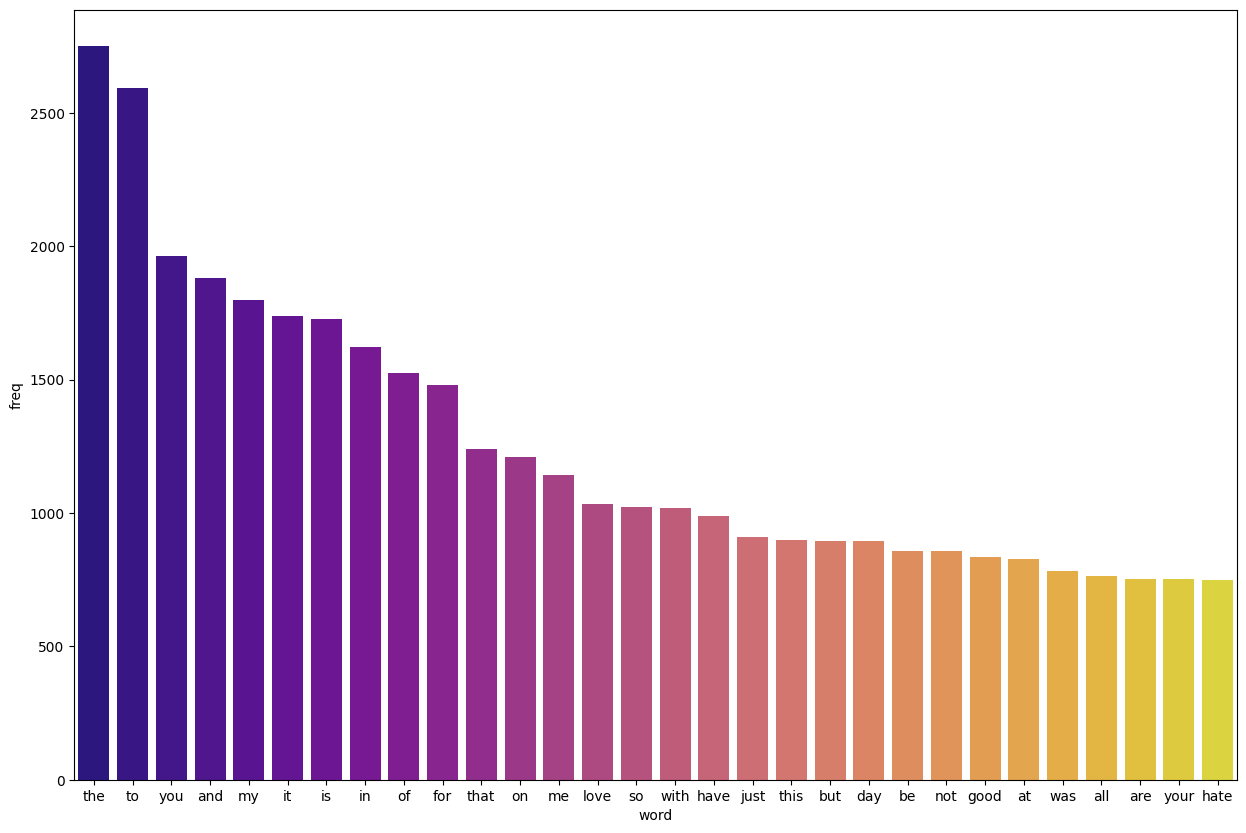

In [ ]:
bow = tfidf.fit_transform(data_train.iloc[:,0].astype('U'))
word_freq = dict(zip(tfidf.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

In [ ]:
# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_train.iloc[:,0].astype('U'))
X_train_count =  count_vect.transform(X_train.astype('U'))
X_val_count =  count_vect.transform(X_val.astype('U'))

(55773, 36739)


<ipython-input-30-2aca7ac8f3d4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")


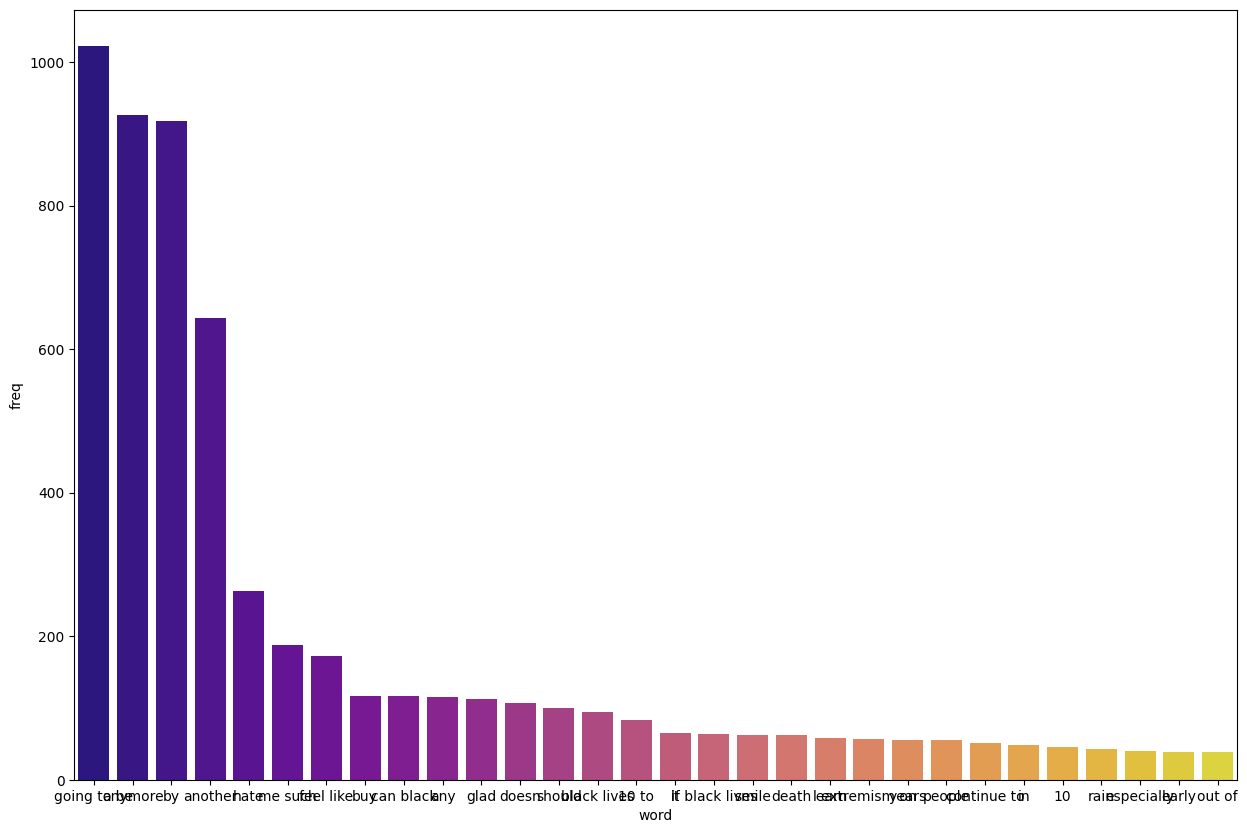

In [ ]:
bow = count_vect.fit_transform(data_train.iloc[:,0].astype('U'))
print(bow.shape)
word_freq = dict(zip(tfidf.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(30), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="word", y="freq", data= word_counter_df, ax=ax, palette="plasma")
plt.show();

In [ ]:
logreg1 = LogisticRegression(C=1, max_iter=500)
logreg1.fit(X_train_count, y_train)
y_pred = logreg1.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))

log reg count vectors accuracy 0.5966563869501704


In [ ]:
tweets = pd.DataFrame(["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
       ])

tweet_count = count_vect.transform(tweets[0])

In [ ]:
tweet_pred = logreg1.predict(tweet_count)
for i in range(len(tweets)):
  if(tweet_pred[i] == 0):
    print("Neutral")
  elif(tweet_pred[i] == 1):
    print("Happy")
  elif(tweet_pred[i] == 2):
    print("sad")
  elif(tweet_pred[i] == 3):
    print("love")
  else:
    print("anger")
#tweets[0]

Happy
love
sad
anger
anger
love
sad
anger
Neutral
Neutral
sad
Happy
Neutral
anger
Neutral
sad


In [ ]:
import pickle

# Save the model, prep function, and count_vect in a dictionary
data = {
    'model': logreg1,
    'prep': prep,
    'count_vect': count_vect
}

with open('/content/drive/MyDrive/DL/emo.pkl', 'wb') as file:
    pickle.dump(data, file)